<div class="alert">
    <h1 align="center">Face Recognition</h1>
    <h3 align="center"><a href="http://www.github.com/amirjahantab/">Amirreza Jahantab</a></h3>
</div>

## Introduction

<h6>Face Recognition:</h6> 
 - Many classes, but very few examples for each class.

## Topics

- Face Recognition
- Siamese Network
- Triplet loss and Contrastive loss
- Defining and implementing our Dataset class.

## Libraries

In [7]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import os
import sys
import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import torchvision
import torchvision.utils
import torchvision.models as models
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset

from data_utils import create_validation_data

use_gpu = torch.cuda.is_available()

In [8]:
use_gpu

True

Helper methods

In [10]:
def get_model(model_name, pretrained=True):
    return models.__dict__[model_name](pretrained)


def imshow(img, text=None):
    img_np = img.numpy().transpose((1, 2, 0)) # (C, H, W) to (H, W, C)
    plt.axis("off")
    if text:
        plt.text(175, 8, text, style='italic', fontweight='bold',
                 bbox={'facecolor': 'white', 'alpha': 0.8, 'pad': 10})
    plt.imshow(img_np)
    plt.show()

## Data

Here, we will use [Cambridge AT&T Face Dataset](https://www.kaggle.com/kasikrit/att-database-of-faces).
- It contains images from 40 different persons.
- For each person, there are 10 different images.

<img src='imgs/ATT_Face_Dataset-4rows.png' width='80%'/>

In [14]:
DATA_DIR = "G:\\FaceRecognition\\dataset\\"
train_dir = f'{DATA_DIR}train'
valid_dir = f'{DATA_DIR}valid'

sz = 96
batch_size = 16
embed_size = 128
num_epochs = 10

cnn_name = 'resnet50'

In [15]:
# make validation dataset
if not os.path.exists(valid_dir):
    create_validation_data(train_dir, valid_dir, split=0.20, ext='jpg')

### Dataset

In many problems, we need to define our own Dataset class. To define a new Dataset, you should:

1. Create a subclass of `torch.utils.data.Dataset`
2. Override the following three methods:
 - The constructor or `__init__()`: this method is required to initialize the dataset object.
 - The `__getitem__()` method: this methos enables us to access each training data using its index. In other words, we can use the dataset as a simple list or sequence.
 - The `__len__()` method: this method returns number of data in the dataset.

In [19]:
class TripletNetworkDataset(Dataset):
    
    def __init__(self, imgs, transform=None):
        self.imgs = imgs
        self.transform = transform or transforms.ToTensor()
        
    def __getitem__(self, index):
        # Select anchor image and its label from dataset
        anchor, anchor_label = self.imgs[index]
        
        # Randomly select a positive and a negative example
        positive = random.choice([img for img, lbl in self.imgs if lbl == anchor_label])
        negative = random.choice([img for img, lbl in self.imgs if lbl != anchor_label])
        
        # read the images (anchor, positive and negative images)
        anc_img = Image.open(anchor).convert('RGB')
        pos_img = Image.open(positive).convert('RGB')
        neg_img = Image.open(negative).convert('RGB')
        
        # perform any required transformation (if any)
        if self.transform is not None:
            anc_img = self.transform(anc_img)
            pos_img = self.transform(pos_img)
            neg_img = self.transform(neg_img)
        
        return anc_img, pos_img, neg_img
    
    def __len__(self):
        return len(self.imgs)

#### Training data

In [21]:
zoom = int((1.0 + random.random() / 10.0) * sz)  # up to 10 percent zoom

tfms = transforms.Compose([
    transforms.Resize((zoom, zoom)),
    transforms.RandomCrop(sz),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(5),
    transforms.ToTensor()
])

face_dataset = datasets.ImageFolder(train_dir)
train_ds = TripletNetworkDataset(face_dataset.imgs, transform=tfms)
train_dl = DataLoader(train_ds, batch_size=8, shuffle=True, num_workers=0)

#### Validation data

In [23]:
valid_tfms = transforms.Compose([
    transforms.Resize((zoom, zoom)),
    transforms.ToTensor()
])

valid_face_dataset = datasets.ImageFolder(valid_dir)
valid_ds = TripletNetworkDataset(valid_face_dataset.imgs, transform=valid_tfms)
valid_dl = DataLoader(valid_ds, batch_size=batch_size, shuffle=False, num_workers=0)

### Visualize dataset

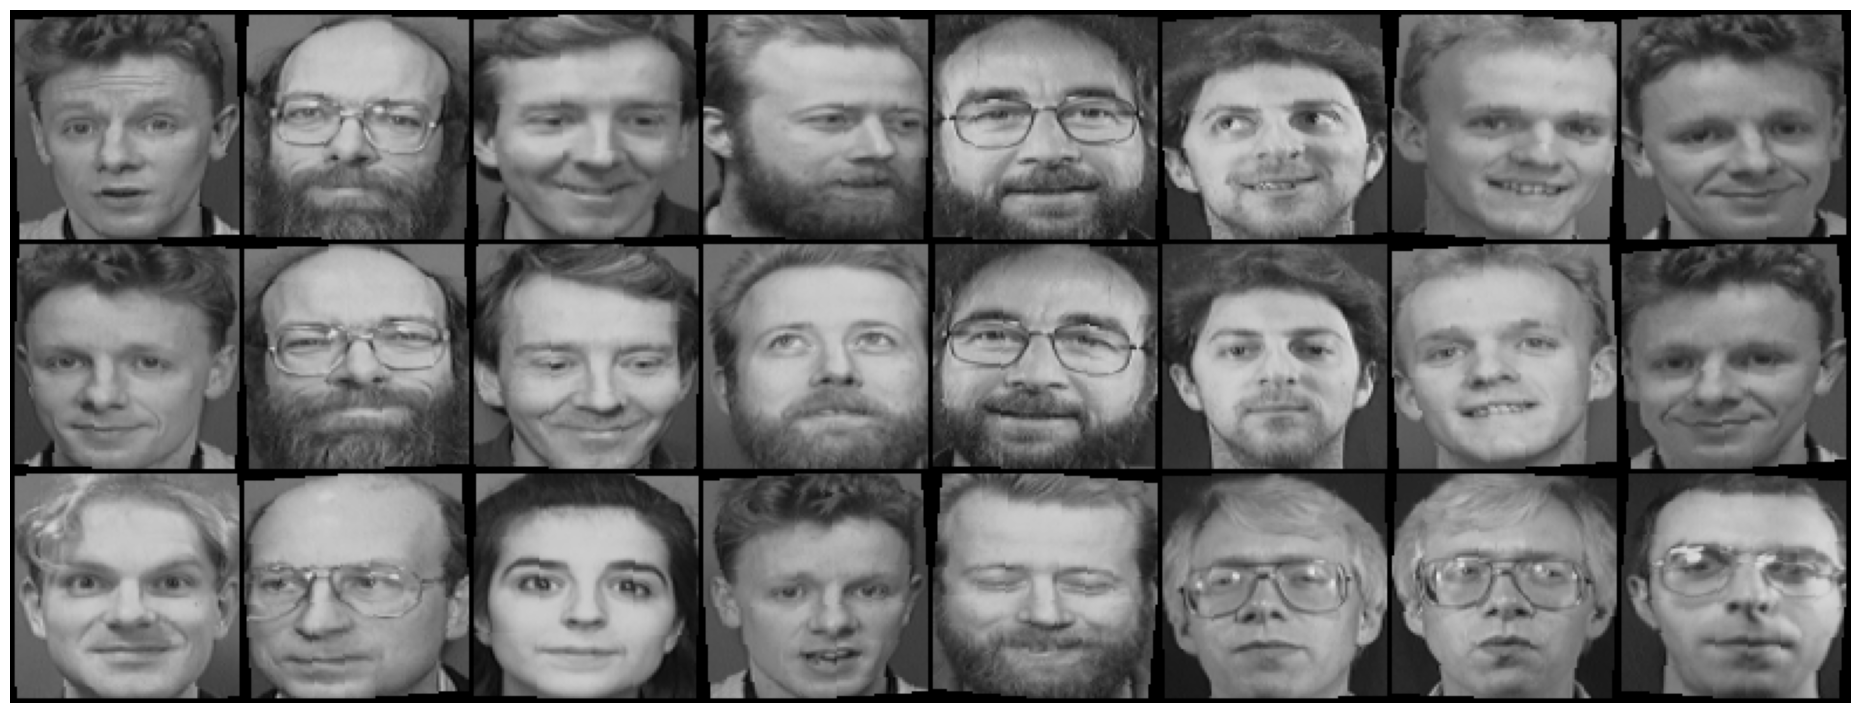

In [25]:
anch_imgs, pos_imgs, neg_imgs = next(iter(train_dl))
concat = torch.cat((anch_imgs, pos_imgs, neg_imgs), 0) # This function concatenates the given tensors along a specified dimension.
plt.figure(figsize=(24, 9))
imshow(torchvision.utils.make_grid(concat, nrow=8))

## Model: Triplet Netwok
The TripletNetwork class is designed to take a pre-trained model and modify its final layer to produce embeddings of a specified size.

In [37]:
class TripletNetwork(nn.Module):
    
    def __init__(self, model, embed_size):
        super(TripletNetwork, self).__init__()
        num_features = model.fc.in_features
        model.fc = nn.Sequential(
            nn.Linear(num_features, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),           
            nn.Linear(512, embed_size))
        self.model = model
        
    def forward(self, anc, pos, neg):
        f_anc = self.model(anc)
        f_pos = self.model(pos)
        f_neg = self.model(neg)
        return f_anc, f_pos, f_neg

## Loss: Triplet Loss
Given a triplet $(a, p, n)$, the loss is defined as following:

$$L(a, p, n) = \max (\lVert f(a) - f(p) \rVert^2 - \lVert f(a) - f(n) \rVert^2 + \alpha, 0)$$

In wich:
- $a$ is the anchor image
- $p$ is the positive example, and
- $n$ is the negative example.

Also, $f(.)$ is the vector of features extracted from a CNN (i.e., embedding vector).

In [39]:
class TripletLoss(nn.Module):

    def __init__(self, margin=0.2):
        super(TripletLoss, self).__init__()
        self.margin = margin

    def forward(self, f_anc, f_pos, f_neg):
        pos_distance = F.pairwise_distance(f_anc, f_pos)
        neg_distance = F.pairwise_distance(f_anc, f_neg)
        loss = torch.sum(torch.clamp(torch.pow(pos_distance, 2) - \
                                     torch.pow(neg_distance, 2) + self.margin, min=0))
        return loss

## Train

In [41]:
def train_step(model, train_dl, criterion, optimizer, device):
    model.train()
    
    N = len(train_dl.dataset)
    steps = N // train_dl.batch_size
    avg_loss = 0.0
    
    for i, (anc, pos, neg) in enumerate(train_dl):
        anc, pos, neg = anc.to(device), pos.to(device), neg.to(device)
        
        # forward
        f_anc, f_pos, f_neg = model(anc, pos, neg)
        
        # loss
        loss = criterion(f_anc, f_pos, f_neg)
        avg_loss = (avg_loss * i + loss.item()) / (i + 1)
        
        # backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # report
        sys.stdout.flush()
        sys.stdout.write("\r Training Step [{:2d}/{:2d}]: loss {:.5f}  ".format(i+1, steps, avg_loss))
        
    print()

    return model, avg_loss    


def validate_step(model, valid_dl, criterion, device):
    model.eval()
    
    N = len(valid_dl.dataset)
    steps = N // valid_dl.batch_size
    avg_loss = 0.0
    
    with torch.no_grad():
        for i, (anc, pos, neg) in enumerate(valid_dl):
            anc, pos, neg = anc.to(device), pos.to(device), neg.to(device)

            f_anc, f_pos, f_neg = model(anc, pos, neg)
            loss = criterion(f_anc, f_pos, f_neg)
            avg_loss = (avg_loss * i + loss.item()) / (i + 1)

            # report
            sys.stdout.flush()
            sys.stdout.write("\r Validation Step [{:2d}/{:2d}]: loss {:.5f}  ".format(i+1, steps, avg_loss))
    print()
    
    return avg_loss


def train(model, train_dl, valid_dl, criterion, optimizer, device, scheduler=None, num_epochs=10):
    best_loss = float('inf')
    best_weights = model.state_dict().copy()
    
    train_loss_history, valid_loss_history = [], []
    
    for epoch in range(num_epochs):
        print(f'Epoch {epoch + 1}\n--------')
        
        model, train_loss = train_step(model, train_dl, criterion, optimizer, device)
        valid_loss = validate_step(model, valid_dl, criterion, device)
        if scheduler:
            scheduler.step()
            
        train_loss_history.append(train_loss)
        valid_loss_history.append(valid_loss)
        
        if valid_loss < best_loss:
            best_loss = valid_loss
            best_weights = model.state_dict().copy()
        print()
    loss_history = (train_loss_history, valid_loss_history)
    model.load_state_dict(best_weights)
    return model, best_weights, loss_history

In [43]:
# data
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True,  num_workers=0)
valid_dl = DataLoader(valid_ds, batch_size=batch_size, shuffle=False, num_workers=0)
 
# model
cnn = get_model(cnn_name)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = TripletNetwork(cnn, embed_size).to(device)

# loss and optimizer
criterion = TripletLoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.0002)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

C:\Users\Amir\anaconda3\Lib\site-packages\torchvision\models\_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(
C:\Users\Amir\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


## Training

In [47]:
model, best_weights, loss_hist = train(model, 
                                       train_dl, valid_dl, 
                                       criterion, optimizer, 
                                       device,
                                       scheduler, 
                                       num_epochs=num_epochs)

Epoch 1
--------
 Training Step [18/17]: loss 21.11617  
 Validation Step [ 8/ 7]: loss 8.49268   

Epoch 2
--------
 Training Step [18/17]: loss 11.91913  
 Validation Step [ 8/ 7]: loss 1.28993  

Epoch 3
--------
 Training Step [18/17]: loss 6.87007  
 Validation Step [ 8/ 7]: loss 6.28226   

Epoch 4
--------
 Training Step [18/17]: loss 13.06100  
 Validation Step [ 8/ 7]: loss 1.20522  

Epoch 5
--------
 Training Step [18/17]: loss 11.43982  
 Validation Step [ 8/ 7]: loss 6.13617  

Epoch 6
--------
 Training Step [18/17]: loss 13.68318  
 Validation Step [ 8/ 7]: loss 1.04373  

Epoch 7
--------
 Training Step [18/17]: loss 8.19898   
 Validation Step [ 8/ 7]: loss 0.50343  

Epoch 8
--------
 Training Step [18/17]: loss 1.56411  
 Validation Step [ 8/ 7]: loss 0.03643  

Epoch 9
--------
 Training Step [18/17]: loss 4.16677  
 Validation Step [ 8/ 7]: loss 0.00000  

Epoch 10
--------
 Training Step [18/17]: loss 3.29138  
 Validation Step [ 8/ 7]: loss 0.00000  



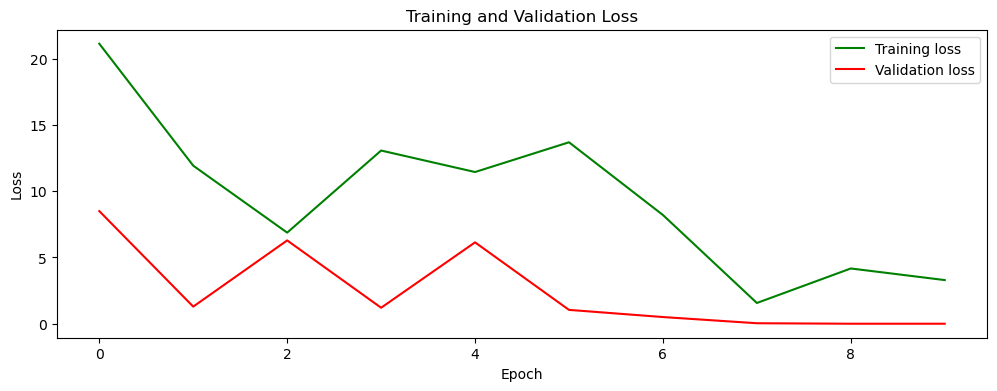

In [53]:
plt.figure(figsize=(12, 4))
plt.plot(loss_hist[0], 'g', label='Training loss')
plt.plot(loss_hist[1], 'r', label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title("Training and Validation Loss");

## Testing

In [49]:
valid_dl = DataLoader(valid_ds, batch_size=1, shuffle=True)

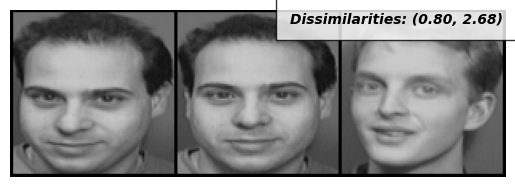

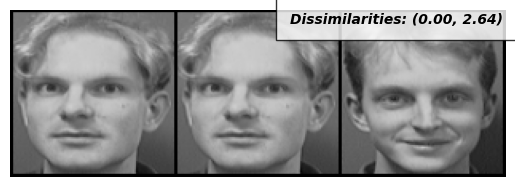

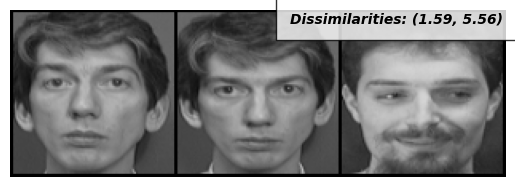

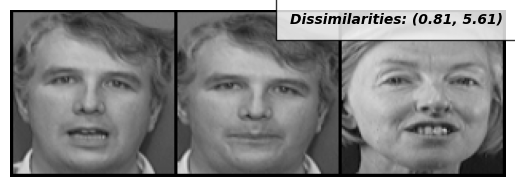

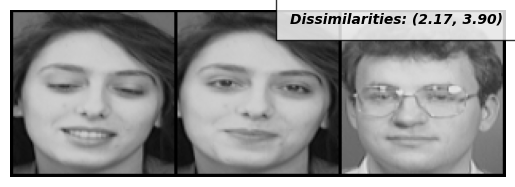

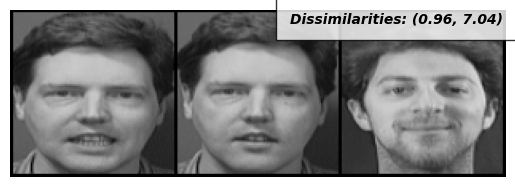

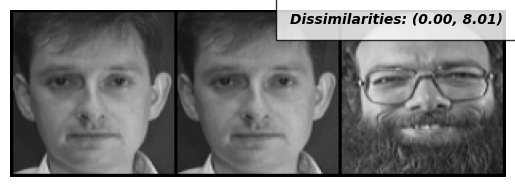

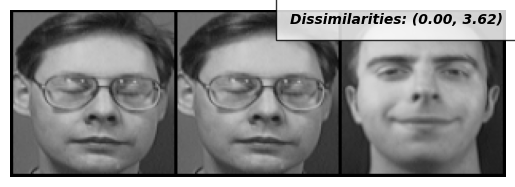

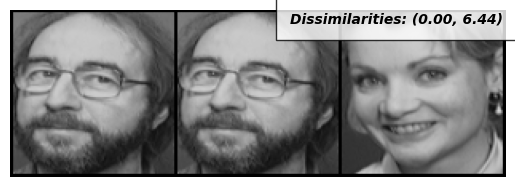

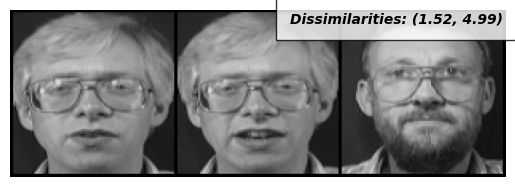

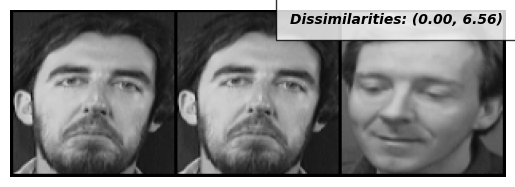

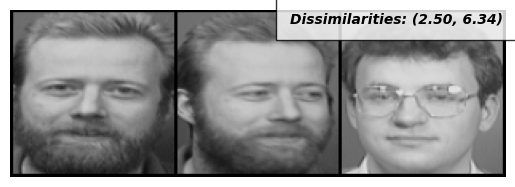

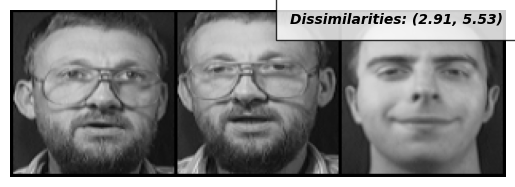

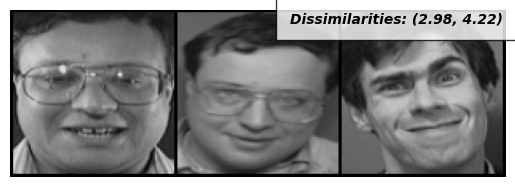

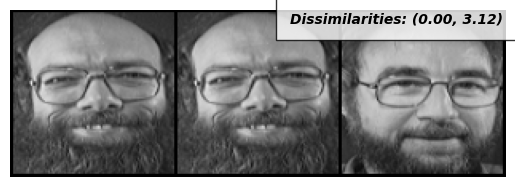

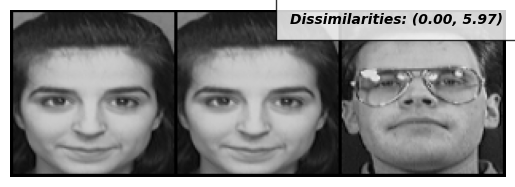

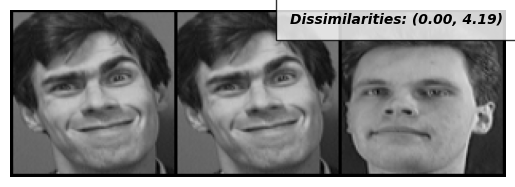

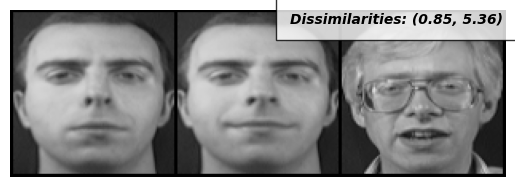

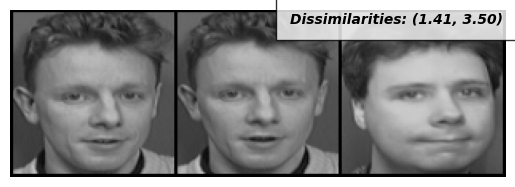

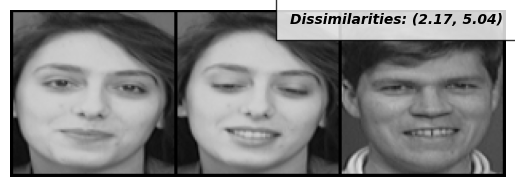

In [50]:
model.eval()

dataiter = iter(valid_dl)

with torch.no_grad():
    for i in range(20):
        x0, x1, x2 = next(dataiter)
        concat = torch.cat((x0, x1, x2), 0)
        f0, f1, f2 = model(x0.to(device), x1.to(device), x2.to(device))
        pos_distance = F.pairwise_distance(f0, f1)
        neg_distance = F.pairwise_distance(f0, f2)
        imshow(torchvision.utils.make_grid(concat), f'Dissimilarities: ({pos_distance.item():.2f}, {neg_distance.item():.2f})')